phi: 0.217 | uniform size: (19, 19)
Manipulator at [49, 49]


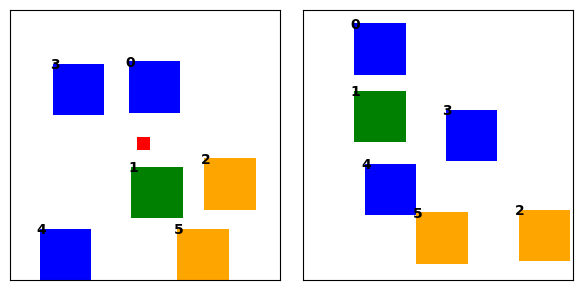

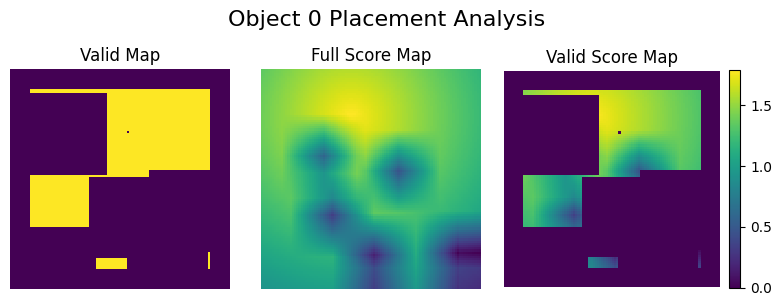

In [1]:
import os
import time
import json
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import cProfile, pstats
from pandas.api.types import CategoricalDtype
from matplotlib import colormaps

from core.env.scene_manager import Indices, SceneManager, show_valid_score_map, draw_dependency_graph
from core.planners.utils import env_cost, evaluate_alg, plan_refinement
from core.planners.Labbe import Labbe, Labbe_S
from core.planners.Strap import StrapGA, StrapGA_S

phi = 0.2
num_objects = 6
grid_size = (100, 100)

env = SceneManager(
	mode='stationary', num_objects=num_objects, 
	grid_size=grid_size, phi=phi, verbose=1
)
env.reset(use_stack=False, use_sides=False)
initial_scene, target_scene = env.initial_x.clone(), env.target_x.clone()
env.reset(initial_scene, target_scene)
env.render(show_manipulator=True, fig_size=3)
show_valid_score_map(env, obj=0)
# show_valid_score_map(env, obj=0)
# draw_dependency_graph(env, fig_size=(3, 3))

In [2]:
evaluate_alg(env, Labbe, initial_scene, target_scene, num_runs=1, c=0.1, time_limit=20);
evaluate_alg(env, Labbe_S, initial_scene, target_scene, num_runs=1, c=0.1, time_limit=20, static_stack=False);

--------Labbe--------
plan: [46662, 2096, 34692, 13958, 58481, 1458, 28419]
elapsed_time: 0.152s
steps: 47
Moved 4 to: [66 32] | cost: 0.971 | done: False
Moved 0 to: [20 66] | cost: 0.787 | done: False
Moved 3 to: [46 62] | cost: 1.027 | done: False
Moved 1 to: [39 28] | cost: 0.807 | done: False
Moved 5 to: [84 51] | cost: 1.076 | done: False
Moved 0 to: [14 28] | cost: 1.242 | done: False
Moved 2 to: [83 89] | cost: 1.660 | done: True
episode cost: 7.569
--------Labbe_S--------
plan: [46662, 38650, 13958, 58481, 1458, 34692, 28419]
elapsed_time: 0.115s
steps: 37
Moved 4 to: [66 32] | cost: 0.971 | done: False
Moved 3 to: [86 20] | cost: 1.149 | done: False
Moved 1 to: [39 28] | cost: 0.972 | done: False
Moved 5 to: [84 51] | cost: 1.076 | done: False
Moved 0 to: [14 28] | cost: 1.047 | done: False
Moved 3 to: [46 62] | cost: 1.504 | done: False
Moved 2 to: [83 89] | cost: 1.193 | done: True
episode cost: 7.911


In [3]:
num_runs = 1
score_sorting = False
num_buffers = 4
time_limit = 20

# prof = cProfile.Profile()
# prof.enable()
evaluate_alg(
	env, StrapGA, initial_scene, target_scene, 
	num_runs=num_runs, score_sorting=score_sorting,
	num_buffers=num_buffers, time_limit=time_limit
);
# prof.disable()
# pstats.Stats(prof).sort_stats('tottime').print_stats(30);

--------StrapGA--------
plan: [1180, 34692, 13958, 1458, 58481, 28419, 46662]
elapsed_time: 20.003s
steps: 10482
Moved 0 to: [11 50] | cost: 0.586 | done: False
Moved 3 to: [46 62] | cost: 0.915 | done: False
Moved 1 to: [39 28] | cost: 0.807 | done: False
Moved 0 to: [14 28] | cost: 0.778 | done: False
Moved 5 to: [84 51] | cost: 1.282 | done: False
Moved 2 to: [83 89] | cost: 0.767 | done: False
Moved 4 to: [66 32] | cost: 1.402 | done: True
episode cost: 6.538


In [4]:
static_stack = False

# prof = cProfile.Profile()
# prof.enable()
evaluate_alg(
	env, StrapGA_S, initial_scene, target_scene, 
	num_runs=num_runs, score_sorting=score_sorting, static_stack=static_stack,
	num_buffers=num_buffers, time_limit=time_limit
);
# prof.disable()
# pstats.Stats(prof).sort_stats('tottime').print_stats(30);

--------StrapGA_S--------
plan: [33459, 1458, 34692, 13958, 46662, 58481, 28419]
elapsed_time: 20.027s
steps: 9199
Moved 3 to: [34 29] | cost: 0.576 | done: False
Moved 0 to: [14 28] | cost: 0.734 | done: False
Moved 3 to: [46 62] | cost: 0.751 | done: False
Moved 1 to: [39 28] | cost: 0.807 | done: False
Moved 4 to: [66 32] | cost: 0.985 | done: False
Moved 5 to: [84 51] | cost: 0.867 | done: False
Moved 2 to: [83 89] | cost: 1.292 | done: True
episode cost: 6.012


In [5]:
# plan = [7535, 33, 38305, 73443, 18174, 23115, 55699, 14770, 57476, 28, 65808, 14276, 41576]
# env_cost(env, plan, initial_scene, target_scene, log=True)

# print('-----')
# plan_refinement(env, plan, initial_scene, target_scene, verbose=1);
# print('-----')
# plan_refinement(env, plan, initial_scene, target_scene, refine_mode="stack", verbose=1);

# Comparison

In [6]:
def scene_json_to_x(json_scene):
	initial_x = torch.tensor([
		[obj['label'], *obj['size'], *obj['initial_pos'], *obj['initial_relation']]
		for obj in json_scene['objects']
	], dtype=torch.long)

	target_x = torch.tensor([
		[obj['label'], *obj['size'], *obj['target_pos'], *obj['target_relation']]
		for obj in json_scene['objects']
	], dtype=torch.long)

	return initial_x, target_x

def load_json_scenes(num_objects, grid_size, phi, num_scenes=None):
	scenes = []
	dir_path = f'abstract_scenes/scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'

	for filename in os.listdir(dir_path):
		if not filename.endswith('.json'):
			continue
		
		with open(os.path.join(dir_path, filename), 'r') as f:
			scene = json.load(f)
		
		scenes.append(scene)
	
	# Sort the scenes by id
	scenes.sort(key=lambda x: x['scene_id'])
	
	if num_scenes is not None:
		return scenes[:num_scenes]
	return scenes

def load_scenes(num_objects, grid_size, phi):
	scenes = []

	json_scenes = load_json_scenes(num_objects, grid_size, phi)
	for json_scene in json_scenes:
		initial_x, target_x = scene_json_to_x(json_scene)
		scenes.append({
			'initial_scene': initial_x,
			'target_scene': target_x
		})

	return scenes

def save_runs(json_scenes, env, phi, alg, file_name, num_runs=1, **kwargs):
	dir_path = f'abstract_scenes/runs/phi_{phi}/{env.mode}/g{env.grid_size[0]}.{env.grid_size[1]}/n{env.N}'
	os.makedirs(dir_path, exist_ok=True)
	
	data_path = os.path.join(dir_path, f'{file_name}.csv')

	file_exists = os.path.exists(data_path)
	if file_exists:
		df = pd.read_csv(data_path, converters={
			'plans': eval, 'steps': eval,
			'elapsed_times': eval, 'costs': eval
		})
	else:
		df = pd.DataFrame()

	print(f'----{alg.__name__}:{file_name}----')
	total_runs = len(json_scenes) * num_runs
	pbar = tqdm(total=total_runs, unit='run')

	for scene_idx, json_scene in enumerate(json_scenes):
		scene_id = json_scene['scene_id']
		already_num_runs = 0
		remaining_num_runs = num_runs
		if file_exists and scene_id in df['scene_id'].values:
			idx = df.index[df['scene_id'] == scene_id][0]
			already_num_runs = len(df.at[idx, 'plans'])
			remaining_num_runs = num_runs - already_num_runs
			pbar.update(already_num_runs)
			if remaining_num_runs <= 0:
				pbar.set_description(f'Skipping scene {scene_id} - already solved {already_num_runs} times')
				continue

		for run_idx in range(1, remaining_num_runs + 1):
			pbar.set_description(f'Scene {scene_idx}/{len(json_scenes)} - Run {run_idx+already_num_runs}/{num_runs}')

			initial_x, target_x = scene_json_to_x(json_scene)
			initial_x, target_x = initial_x.to(torch.long), target_x.to(torch.long)
			env.reset(initial_x, target_x)
			plan, step, elapsed_time = alg(env).solve(**kwargs)
			cost = env_cost(env, plan, initial_x, target_x, log=False)

			if file_exists and scene_id in df['scene_id'].values:
				idx = df.index[df['scene_id'] == scene_id][0]
				df.at[idx, 'plans'] += [plan]
				df.at[idx, 'steps'] += [step]
				df.at[idx, 'elapsed_times'] += [elapsed_time]
				df.at[idx, 'costs'] += [cost]
			else:
				new_row = pd.DataFrame([{
					'scene_id': scene_id,
					'mode': env.mode,
					'n': json_scene['num_objects'],
					'grid_size': json_scene['grid_size'],
					'alg': file_name,
					'plans': [plan],
					'steps': [step],
					'elapsed_times': [elapsed_time],
					'costs': [cost],
				}])
				df = pd.concat([df, new_row], ignore_index=True)

			# Sort and save
			df = df.sort_values(by='scene_id').reset_index(drop=True)
			df.to_csv(data_path, index=False)
			file_exists = True

			pbar.update(1)
		pbar.set_description(f'Scene {scene_idx}/{len(json_scenes)} - Run {run_idx+already_num_runs}/{num_runs}')
		
	pbar.close()


In [ ]:
num_objects = 8
grid_size = (100, 100)
phi = 0.5
static_stack = True
json_scenes = load_json_scenes(num_objects, grid_size, phi)
initial_scene, target_scene = scene_json_to_x(json_scenes[4])
env = SceneManager('stationary', num_objects, grid_size, phi=phi, static_stack=True, verbose=1)
env.reset(initial_scene, target_scene)
env.render()

### runs

In [ ]:
def run_(num_runs, mode, num_objects, grid_size, phi, time_limit):
	num_buffers = 4
	env = SceneManager(
		mode=mode, num_objects=num_objects, 
		grid_size=grid_size, phi=phi, verbose=0
	)

	json_scenes = load_json_scenes(num_objects, grid_size, phi, num_scenes=None)

	save_runs(json_scenes, env, phi, Labbe, "Labbe", num_runs=num_runs, 
		c=0.1, time_limit=time_limit
	)
	save_runs(json_scenes, env, phi, Labbe_S, "Labbe+S", num_runs=num_runs, 
		c=0.1, time_limit=time_limit
	)
	save_runs(json_scenes, env, phi, StrapGA, f"StrapGA_{num_buffers}b", num_runs=num_runs, 
		num_buffers=num_buffers, time_limit=time_limit
	)
	save_runs(json_scenes, env, phi, StrapGA_S, f"StrapGA+S_{num_buffers}b", num_runs=num_runs, 
		num_buffers=num_buffers, time_limit=time_limit
	)

	save_runs(json_scenes, env, phi, Labbe_S, "Labbe+SS", num_runs=num_runs, 
		c=0.1, time_limit=time_limit, static_stack=True
	)
	save_runs(json_scenes, env, phi, StrapGA_S, f"StrapGA+SS_{num_buffers}b", num_runs=num_runs, 
		num_buffers=num_buffers, time_limit=time_limit, static_stack=True
	)

	# print('-- Score Sorting --')

	# save_runs(json_scenes, env, phi, StrapGA, f"StrapGA_sort_{num_buffers}b", num_runs=num_runs, 
	# 	num_buffers=num_buffers, time_limit=time_limit, score_sorting=True
	# )
	# save_runs(json_scenes, env, phi, StrapGA_S, f"StrapGA+S_sort_{num_buffers}b", num_runs=num_runs, 
	# 	num_buffers=num_buffers, time_limit=time_limit, score_sorting=True
	# )

	# save_runs(json_scenes, env, phi, StrapGA_S, f"StrapGA+SS_sort_{num_buffers}b", num_runs=num_runs, 
	# 	num_buffers=num_buffers, time_limit=time_limit, static_stack=True, score_sorting=True
	# )
	
phi = 0.2
num_runs = 1
time_limit = 360
grid_size = (100, 200)
mode = 'mobile'

# run_(num_runs=num_runs, mode=mode, num_objects=3, grid_size=grid_size, phi=phi, time_limit=time_limit)

### Plots

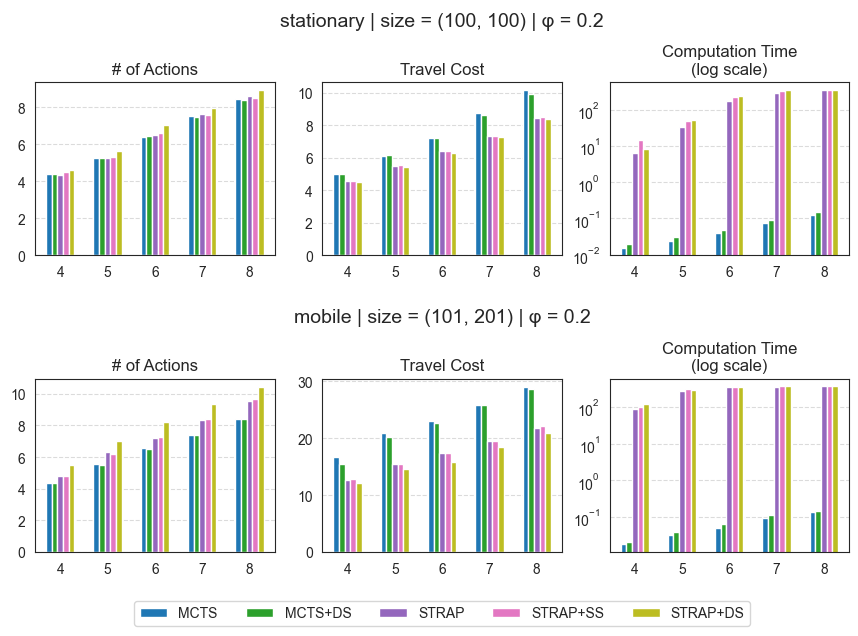

In [16]:
sns.set_style('white')

def load_runs(mode, grid_size, algs, n_values, phi, runs_dir='runs', refine=False):
	all_dfs = []

	for num_objects in n_values:
		for alg_name in algs:
			filename = f'{runs_dir}/phi_{phi}/{mode}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/{alg_name}.csv'
			if not os.path.isfile(filename):
				continue

			# Read CSV
			df = pd.read_csv(filename)

			if refine:
				# Determine refinement algorithm based on alg_name
				if 'Labbe+SS' in alg_name or 'StrapGA+SS' in alg_name:
					refine_mode = "stack"
					static_stack = True
				elif 'Labbe+S' in alg_name or 'StrapGA+S' in alg_name:
					refine_mode = "stack"
					static_stack = False
				else:
					refine_mode = None
					static_stack = False

				# Create temporary environment for refinement
				temp_env = SceneManager(
					mode=mode, num_objects=num_objects, grid_size=grid_size, 
					static_stack=static_stack, phi=phi, verbose=0
				)
				
				# Process each row for refinement
				for idx, row in df.iterrows():
					scene_id = row['scene_id']
					plans = eval(row['plans'])
					steps = eval(row['steps'])
					elapsed_times = eval(row['elapsed_times'])
					costs = eval(row['costs'])
					
					refined_plans = []
					refined_costs = []
					refined_elapsed_times = []
					
					# Load the corresponding scene
					scene_filename = f'abstract_scenes/scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}/scene_{scene_id:04d}.json'
					if os.path.exists(scene_filename):
						with open(scene_filename, 'r') as f:
							json_scene = json.load(f)
						initial_x, target_x = scene_json_to_x(json_scene)
						
						# Refine each run
						for i, (plan, elapsed_time, cost) in enumerate(zip(plans, elapsed_times, costs)):
							if plan is not None and cost is not None:
								temp_env.reset(initial_x, target_x)
								
								refined_plan, refined_cost, refinement_time = refine_until_convergence(
									temp_env, plan, initial_x, target_x, refine_mode, verbose=0
								)
								
								refined_plans.append(refined_plan)
								refined_costs.append(refined_cost)
								refined_elapsed_times.append(elapsed_time + refinement_time)
							else:
								# Keep failed runs as they are
								refined_plans.append(plan)
								refined_costs.append(cost)
								refined_elapsed_times.append(elapsed_time)
					else:
						print(f"Warning: Scene file {scene_filename} not found. Skipping refinement for scene {scene_id}")
						refined_plans = plans
						refined_costs = costs
						refined_elapsed_times = elapsed_times
					
					# Update the dataframe row
					df.at[idx, 'plans'] = str(refined_plans)
					df.at[idx, 'costs'] = str(refined_costs)
					df.at[idx, 'elapsed_times'] = str(refined_elapsed_times)

			# calculate the mean not-None costs
			df['cost'] = df['costs'].apply(lambda x: 
				np.mean([cost for cost in eval(x) if cost is not None]) 
				if isinstance(eval(x), list) and any(cost is not None for cost in eval(x)) 
				else np.nan
			)
			df['step'] = df['steps'].apply(lambda x: np.mean([step for step in eval(x)]))
			df['elapsed_time'] = df['elapsed_times'].apply(lambda x: np.mean([time for time in eval(x)]))
			# Add plan length calculation
			df['plan_length'] = df['plans'].apply(lambda x: 
				np.mean([len(plan) for plan in eval(x) if plan is not None]) 
				if isinstance(eval(x), list) and any(plan is not None for plan in eval(x)) 
				else np.nan
			)

			all_dfs.append(df)

	# Merge all into one big DataFrame
	if all_dfs:
		merged_df = pd.concat(all_dfs, ignore_index=True)
		return merged_df
	else:
		print("No valid run files found.")
		return pd.DataFrame()  # Return empty DF if nothing was loaded

def process_algorithm_data(df, include_std=False):
	"""
	Process algorithm comparison data and create pivot tables for plotting.
	
	Parameters:
	df: Input dataframe with algorithm results
	include_std: Whether to include standard deviation data
	
	Returns:
	dict: Contains all processed data organized by metric type
	"""
	# Filter successful runs (cost not null = successful run)
	df['success'] = df['cost'].notna()
	df_successful = df[df['success']].copy()
	
	# Preserve algorithm order as they appear in the dataframe
	alg_order = df['alg'].drop_duplicates().tolist()
	alg_dtype = CategoricalDtype(categories=alg_order, ordered=True)
	df['alg'] = df['alg'].astype(alg_dtype)
	df_successful['alg'] = df_successful['alg'].astype(alg_dtype)
	
	# Group data for aggregation
	grouped_successful = df_successful.groupby(['n', 'alg'])
	grouped_all = df.groupby(['n', 'alg'])
	
	# Calculate aggregated metrics for successful runs
	agg_successful = grouped_successful.agg(
		cost_mean=('cost', 'mean'),
		cost_std=('cost', 'std'),
		step_mean=('step', 'mean'),
		step_std=('step', 'std'),
		time_mean=('elapsed_time', 'mean'),
		time_std=('elapsed_time', 'std'),
		plan_length_mean=('plan_length', 'mean'),
		plan_length_std=('plan_length', 'std')
	).reset_index()
	
	# Calculate success rate using all runs
	agg_all = grouped_all.agg(
		success_rate=('success', lambda x: 100 * x.sum() / len(x))
	).reset_index()
	
	# Ensure algorithm column ordering is preserved
	agg_successful['alg'] = agg_successful['alg'].astype(alg_dtype)
	agg_all['alg'] = agg_all['alg'].astype(alg_dtype)
	
	# Create pivot tables for plotting
	mean_data = {
		'cost': agg_successful.pivot(index='n', columns='alg', values='cost_mean')[alg_order],
		'step': agg_successful.pivot(index='n', columns='alg', values='step_mean')[alg_order],
		'time': agg_successful.pivot(index='n', columns='alg', values='time_mean')[alg_order],
		'plan_length': agg_successful.pivot(index='n', columns='alg', values='plan_length_mean')[alg_order],
		'success_rate': agg_all.pivot(index='n', columns='alg', values='success_rate')[alg_order]
	}
	
	std_data = {}
	if include_std:
		std_data = {
			'cost': agg_successful.pivot(index='n', columns='alg', values='cost_std')[alg_order],
			'step': agg_successful.pivot(index='n', columns='alg', values='step_std')[alg_order],
			'time': agg_successful.pivot(index='n', columns='alg', values='time_std')[alg_order],
			'plan_length': agg_successful.pivot(index='n', columns='alg', values='plan_length_std')[alg_order]
		}
	
	return {
		'mean': mean_data,
		'std': std_data,
		'algorithm_order': alg_order
	}

def draw_row(axs, data, std, sr, steps, plan_len, cmap):
    """Shared function to draw algorithm comparison plots in a row."""
    idx = 0
    if plan_len:
        plot_algorithm_bars(data['mean']['plan_length'], '# of Actions', '',
                            data['std'].get('plan_length'), ax=axs[idx], cmap=cmap, show_legend=False)
        idx += 1
    plot_algorithm_bars(data['mean']['cost'], 'Travel Cost', '',
                        data['std'].get('cost'), ax=axs[idx], cmap=cmap, show_legend=False)
    idx += 1
    plot_algorithm_bars(data['mean']['time'], 'Computation Time\n(log scale)', '',
                        data['std'].get('time'), log_scale=True, ax=axs[idx], cmap=cmap, show_legend=False)
    idx += 1
    if steps:
        st = data['mean']['step'] / 1000
        ss = data['std'].get('step') / 1000 if std and 'step' in data['std'] else None
        plot_algorithm_bars(st, 'Step Comparison\n(in thousands)', '', ss, ax=axs[idx], cmap=cmap, show_legend=False)
        idx += 1
    if sr:
        plot_algorithm_bars(data['mean']['success_rate'], 'Success Rate (%)', '', ax=axs[idx], cmap=cmap, show_legend=False)

def compare_algorithms_single_row(df, std=False, sr=False, steps=False, plan_len=False, title=''):
    """
    Create a single row of comparison plots for algorithms.
    """
    if df.empty:
        print("No data to compare.")
        return {}

    processed_data = process_algorithm_data(df, include_std=std)
    mean_data, std_data = processed_data['mean'], processed_data['std']

    num_plots = 2 + sum([sr, steps, plan_len])
    plot_w, plot_h = 3.5, 3
    fig_h = plot_h + 1.5  # increased for more spacing
    fig = plt.figure(figsize=(num_plots * plot_w, fig_h))
    gs = fig.add_gridspec(3, num_plots, height_ratios=[0.6, plot_h, 0.6], hspace=0.6)  # increased spacing

    # Title row
    ax_title = fig.add_subplot(gs[0, :])
    ax_title.axis('off')
    ax_title.text(0.5, 0.5, title, ha='center', va='center', fontsize=14)

    # Plot row
    axs = [fig.add_subplot(gs[1, i]) for i in range(num_plots)]
    cmap = colormaps['tab10']
    
    # Use shared draw_row function
    draw_row(axs, processed_data, std, sr, steps, plan_len, cmap)

    # Legend row
    ax_legend = fig.add_subplot(gs[2, :])
    ax_legend.axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    ax_legend.legend(handles, labels, ncol=len(labels), loc='center')

    plt.show()
    return {'cost': mean_data['cost'], 'plan_length': mean_data['plan_length'], 'success_rate': mean_data['success_rate']}

def compare_algorithms_double_row(df1, df2, std=False, sr=False, steps=False, plan_len=False,
                                title1='', title2=''):
    """
    Create two rows of comparison plots with identical plot-area sizes and consistent spacing.
    """
    if df1.empty or df2.empty:
        print("No data to compare.")
        return {}

    d1 = process_algorithm_data(df1, include_std=std)
    d2 = process_algorithm_data(df2, include_std=std)

    num_plots = 2 + sum([sr, steps, plan_len])
    plot_w, plot_h = 3.5, 3
    fig_h = 2 * plot_h + 2.0  # increased for more spacing
    fig = plt.figure(figsize=(num_plots * plot_w, fig_h))
    gs = fig.add_gridspec(5, num_plots,
                        height_ratios=[0.4, plot_h, 0.4, plot_h, 0.4],
                        hspace=0.6)  # increased spacing

    # Title1
    ax_t1 = fig.add_subplot(gs[0, :]); ax_t1.axis('off')
    ax_t1.text(0.5, 0.5, title1, ha='center', va='center', fontsize=14)
    # Plots1
    axs1 = [fig.add_subplot(gs[1, i]) for i in range(num_plots)]
    # Title2
    ax_t2 = fig.add_subplot(gs[2, :]); ax_t2.axis('off')
    ax_t2.text(0.5, 0.5, title2, ha='center', va='center', fontsize=14)
    # Plots2
    axs2 = [fig.add_subplot(gs[3, i]) for i in range(num_plots)]
    cmap = colormaps['tab10']
    
    # Use shared draw_row function for both rows
    draw_row(axs1, d1, std, sr, steps, plan_len, cmap)
    draw_row(axs2, d2, std, sr, steps, plan_len, cmap)

    # Legend
    ax_leg = fig.add_subplot(gs[4, :]); ax_leg.axis('off')
    handles, labels = axs1[0].get_legend_handles_labels()
    ax_leg.legend(handles, labels, ncol=len(labels), loc='center')

    plt.show()

def plot_algorithm_bars(df, title, ylabel, std_data=None, log_scale=False, ax=None, cmap=None, show_legend=True):
	"""
	Create bar plots for algorithm comparison with proper labeling.
	
	Parameters:
	df: Pivot table with algorithm data
	title: Plot title
	ylabel: Y-axis label
	std_data: Standard deviation data for error bars
	log_scale: Whether to use log scale for y-axis
	ax: Matplotlib axes object
	cmap: Color map for bars
	show_legend: Whether to show legend
	"""
	if ax is None:
		fig, ax = plt.subplots(figsize=(6, 4))

	n_values = df.index.tolist()
	algorithms = df.columns.tolist()
	x = np.arange(len(n_values))
	bar_width = 0.12

	colors = [cmap(i / len(algorithms)) for i in range(len(algorithms))]

	# Algorithm name mapping for cleaner labels
	label_mapping = {
		'StrapGA+S_4b': 'STRAP+DS',
		'StrapGA+SS_4b': 'STRAP+SS',
		'StrapGA_4b': 'STRAP',
		'Labbe': 'MCTS',
		'Labbe+S': 'MCTS+DS',
		'Labbe+SS': 'MCTS+SS'
	}

	for i, alg in enumerate(algorithms):
		values = df[alg].values
		errors = std_data[alg].values if std_data is not None and alg in std_data.columns else None
		label = label_mapping.get(alg, alg)

		ax.bar(x + i * bar_width, values, width=bar_width, color=colors[i], 
			label=label, yerr=errors, capsize=5 if errors is not None else 0)

	ax.set_xlabel('')
	ax.set_ylabel(ylabel)
	ax.set_title(title)
	ax.set_xticks(x + bar_width * (len(algorithms) - 1) / 2)
	ax.set_xticklabels(n_values)
	
	if show_legend:
		ax.legend(title='Algorithm')

	if log_scale:
		ax.set_yscale('log')

	ax.grid(axis='y', linestyle='--', alpha=0.7)

phi = 0.2
n_values = [4,5,6,7,8]
algs = ["Labbe", "Labbe+S", "StrapGA_4b", "StrapGA+SS_4b", "StrapGA+S_4b"]

mode = 'stationary'
grid_size = (100, 100)
df1 = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine=False)
title1 = f'{mode} | size = {grid_size} | φ = {phi}'

mode = 'mobile'
grid_size = (101, 201)
df2 = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine=False)
title2 = f'{mode} | size = {grid_size} | φ = {phi}'
compare_algorithms_double_row(df1, df2, plan_len=True, title1=title1, title2=title2);

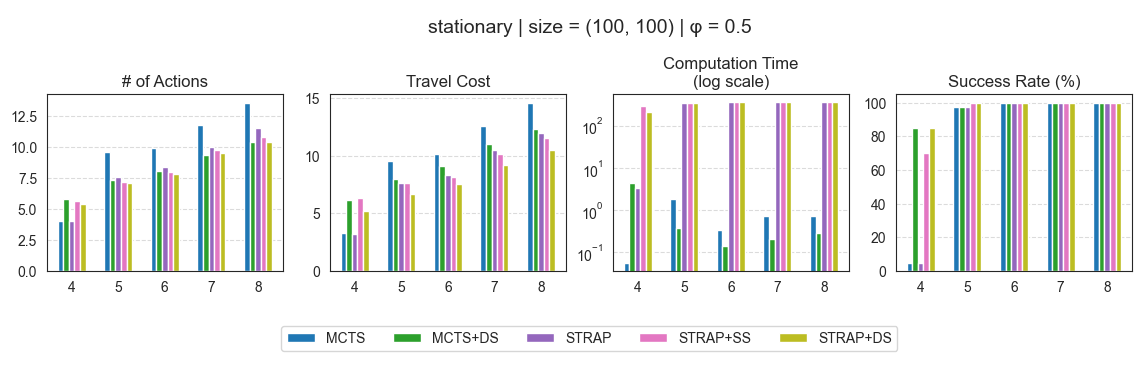

In [44]:
phi = 0.5
n_values = [4,5,6,7,8]
algs = ["Labbe", "Labbe+S", "StrapGA_4b", "StrapGA+SS_4b", "StrapGA+S_4b"]
mode = 'stationary'
grid_size = (100, 100)

df = load_runs(mode, grid_size, algs, n_values, phi, runs_dir='abstract_scenes/runs', refine=False)
data = compare_algorithms_single_row(df, plan_len=True, sr=True, title=f'{mode} | size = {grid_size} | φ = {phi}')

for key in data.keys():
	data[key].columns = ['MCTS', 'MCTS+DS', 'STRAP', 'STRAP+SS', 'STRAP+DS']
	data[key] = data[key].drop(4)


In [45]:
def aggregated_per_improvement(df_value, df_sr, col1, col2):
    col1_sum = (df_value[col1] / df_sr[col1] * 100).sum()
    col2_sum = (df_value[col2] / df_sr[col2] * 100).sum()
    # col1_sum = df_value[col1].sum()
    # col2_sum = df_value[col2].sum()
    return ((col1_sum - col2_sum) / col1_sum) * 100

per_imp = aggregated_per_improvement(data['cost'], data['success_rate'], 'STRAP', 'STRAP+SS')
print(f'Cost SS: {per_imp:.3f}%')
per_imp = aggregated_per_improvement(data['cost'], data['success_rate'], 'STRAP', 'STRAP+DS')
print(f'Cost DS: {per_imp:.3f}%')

Cost SS: 2.963%
Cost DS: 11.892%


# Create Scene

In [ ]:
from core.env.scene_manager import cal_density

def make_scenes(env, num_cases, use_stack=False, use_sides=False):
	scenes = []
	for _ in range(num_cases):
		env.reset(use_stack=use_stack, use_sides=use_sides)
		scenes.append({
			'initial_scene': env.initial_x,
			'target_scene': env.target_x
		})
	
	return scenes

def save_scenes(scenes, num_objects, grid_size, phi, verbose=0):
	dir_path = f'abstract_scenes/scenes/phi_{phi}/g{grid_size[0]}.{grid_size[1]}/n{num_objects}'
	os.makedirs(dir_path, exist_ok=True)
	
	for scene in scenes:
		initial_x = scene['initial_scene']
		target_x = scene['target_scene']

		# save the scene in a json file
		objs = []
		for obj in range(num_objects):
			objs.append({
				'object_id': obj,
				'label': initial_x[obj, Indices.LABEL].item(),
				'size': initial_x[obj, Indices.SIZE].tolist(),
				'initial_pos': initial_x[obj, Indices.COORD].tolist(),
				'initial_relation': initial_x[obj, Indices.RELATION].tolist(),
				'target_pos': target_x[obj, Indices.COORD].tolist(),
				'target_relation': target_x[obj, Indices.RELATION].tolist(), 
			})
		
		# Find the id of the current .json files in the dir_path
		files = os.listdir(dir_path)
		scene_id = 0
		while f'scene_{scene_id:04d}.json' in files:
			scene_id += 1

		# create the json scene
		json_scene = {
			'scene_id': scene_id,
			'phi': cal_density(initial_x, grid_size),
			'num_objects': num_objects,
			'grid_size': grid_size,
			'objects': objs
		}

		# Save the scene in a json file
		subfolder_path = os.path.join(dir_path, f'scene_{scene_id:04d}.json')
		with open(subfolder_path, 'w') as f:
			json.dump(json_scene, f, indent=4)
		
		if verbose > 0:
			print(f'Saved {subfolder_path}')

num_cases = 10
n_values = [3, 4, 5, 6, 7, 8]

phi = 0.2
use_sides = False
grid_size = (101, 201)

densities = {}
for num_objects in n_values:
	print(f'--n: {num_objects}--')
	env = SceneManager(mode="stationary", num_objects=num_objects, grid_size=grid_size, phi=phi)
	scenes = make_scenes(env, num_cases, use_sides=use_sides)
	save_scenes(scenes, num_objects, grid_size, phi, verbose=1)
	densities[num_objects] =[]
	for i, scene in enumerate(scenes):
		densities[num_objects].append(cal_density(scene['initial_scene'], grid_size))
